In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem, Draw
import os
from multiprocessing import Pool

from rdkit.Chem.PropertyMol import PropertyMol # Allow pickle on mol props for multiprocessing
from rdkit.Chem import RDConfig # Allow Contrib packages to be used
from rdkit.Chem.Crippen import MolLogP as LogP # Lipophilicity
from rdkit.Chem.QED import default as QED # Quantitiative Estimate of Drug-likeness
from rdkit.Chem.Descriptors import MolWt # Mol Weight
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
# add path for rdkit Contrib packages
from sascorer import calculateScore as SAS # Sythetic Accessiblilty Score

### Combine all sd files from each cycle folder and calculate properties
This should be automatically done at the end of the main script of sample dock, however, if the task was killed by job scheduler before it could finish or any unexpected error occurred during the run, you can use the code below or the post_process.py to combine and calculate the properties of each generated design.

In [4]:
# Directory to the generated designs (all the cycle folders)
directory = '/home/ziqiaoxu/VAE_Raw_Data/SnD-CDK2-5IEV-May21'
directory = os.path.abspath(directory)
print(directory)

/home/ziqiaoxu/VAE_Raw_Data/SnD-CDK2-5IEV-May21


In [5]:
# list of all cycle folders
folders = [x for x in os.listdir(directory) if x.startswith('cycle_')]
# sort folder name
folders.sort(key=lambda x: int(x.strip('cycle_')))
print(folders[-1])

cycle_145


In [6]:
#Function for calculate mol properties for sd files in each folder
def process_by_folder(fd):
    cycle = fd.strip("cycle_")
    sd = directory+'/'+fd+'/ranked_designs.sd'
    if os.path.exists(sd):
        cir_mols = [PropertyMol(m) for m in Chem.SDMolSupplier(sd)]
        for m in cir_mols:
            # Calculate properties for each mol
            m.SetProp('Cycle',cycle)
            m.SetProp('MolWeight', str(MolWt(m)))
            m.SetProp('LogP', str(LogP(m)))
            m.SetProp('QED', str(QED(m)))
            m.SetProp('SAS', str(SAS(m)))
        # Select the highest score design in the cycle
        # (the first one in the ranked sd file) 
        best_mol = cir_mols[0]
    return cir_mols, best_mol

In [7]:
# Multiprocessing on Mol Properties calculations
# Using all available threads minus one
with Pool(processes = os.cpu_count()-1) as pool:
    results = pool.map(process_by_folder, folders)

# Retrieve results
mol_lists, best_mols = zip(*results)
# Create the list of all mols
all_mols = []
for l in mol_lists:
    all_mols.extend(l)
# Convert tuple to list
best_mols = list(best_mols)

In [30]:
# Save mols in sdf files
with open(directory+'/All_Designs.sdf','w') as outfile:
    w = Chem.SDWriter(outfile)
    for m in all_mols:
        w.write(m)
    w.close()

with open(directory+'/Best_Designs.sdf','w') as outfile:
    w = Chem.SDWriter(outfile)
    for m in best_mols:
        w.write(m)
    w.close()

### Load Saved Mol files and make Pandas dataframe

In [31]:
load_dir = '/home/ziqiaoxu/VAE_Raw_Data/SnD-CDK2-5IEV-May21/'
all_mols = [m for m in Chem.SDMolSupplier(load_dir+'/All_Designs.sdf')]
best_mols = [m for m in Chem.SDMolSupplier(load_dir+'/Best_Designs.sdf')]

In [8]:
def create_df(mol_list):
    # Create dataframe with all the properties
    df = pd.DataFrame()

    df['Design'] = [m.GetProp('Name') for m in mol_list]
    df['Cycle'] = [int(m.GetProp('Cycle')) for m in mol_list]
    df['Score'] = [float(m.GetProp('SCORE.INTER')) for m in mol_list]
    df['SMILES'] = [m.GetProp('SMILES') for m in mol_list]
    df['Mol'] = [m for m in mol_list]
    df['LogP'] = [float(m.GetProp('LogP')) for m in mol_list]
    df['QED'] = [float(m.GetProp('QED')) for m in mol_list]
    df['MolWt'] = [float(m.GetProp('MolWeight')) for m in mol_list]
    df['SAS'] = [float(m.GetProp('SAS')) for m in mol_list]
    return df

In [32]:
# Create dataframe from the lists
allscores = create_df(all_mols)
minscores = create_df(best_mols)

# sort the dataframe based on docking scores
sortedscores = minscores.sort_values('Score')
# Drop dulicated entries
sortedscores.drop_duplicates('SMILES', inplace = True, keep = 'first')

# Save as csv
allscores.drop(columns=['Mol']).to_csv(directory+'/allscores.csv', index = False)
sortedscores.drop(columns=['Mol']).to_csv(directory+'/sortedscores.csv', index = False)

minscores.describe()

,Cycle,Score,LogP,QED,MolWt,SAS
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,72.500000,-23.014852,2.385945,0.735632,324.444705,2.035103
std,42.290661,5.915334,0.667455,0.078409,27.744191,0.296206
min,0.000000,-29.370600,0.707900,0.571949,150.177000,1.570086
25%,36.250000,-26.239600,1.912525,0.665804,314.231500,1.872320
50%,72.500000,-24.966850,2.359200,0.752221,326.397500,1.993992
75%,108.750000,-23.642225,2.902400,0.786771,339.299750,2.130113
max,145.000000,-8.917590,3.777600,0.935639,382.489000,3.987501


,Design,Cycle,Score,SMILES,Mol,LogP,QED,MolWt,SAS
11,design_8,11,-29.37060,NS(=O)(=O)c1cccc(NC(=O)c2cccc(Oc3cnccn3)c2)c1,,2.16860,0.709082,370.390,2.100055
114,design_18,114,-28.78160,Cc1nc(CCNC(=O)NCCc2nc3c(s2)CCCC3)cs1,,2.87122,0.841710,350.513,2.555418
33,design_9,33,-28.66800,CC1CCC(NC(=O)NCCc2ccc(S(N)(=O)=O)cc2)CC1,,1.75440,0.761504,339.461,2.025788
131,design_15,131,-28.57170,Cc1cccc(CCNC(=O)NCCc2nc3ccccc3[nH]2)c1,,2.95572,0.652849,322.412,2.002148
6,design_3,6,-28.14610,NS(=O)(=O)c1cccc(NC(=O)c2ccc3ccccc3c2)c1,,2.73950,0.775294,326.377,1.696480
...,...,...,...,...,...,...,...,...,...
67,design_3,67,-9.49658,CCN(CC(=O)OC)C(=O)c1sccc1Br,,2.14570,0.800819,306.181,2.329974
51,design_13,51,-9.43999,CCN(CCC(=O)OC)C(=O)Cc1ccc(C)cc1,,1.94912,0.736944,263.337,1.873356
61,design_11,61,-9.39865,CCN(CC(=O)OC)C(=O)c1ccccc1Br,,2.08420,0.799905,300.152,1.916207
15,design_3,15,-9.13884,COc1ccc2c(c1)OCC2,,1.63010,0.605391,150.177,1.845944

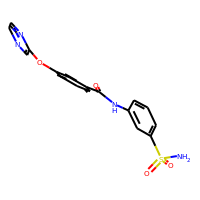
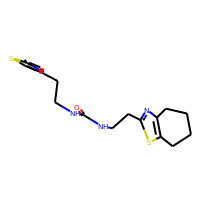
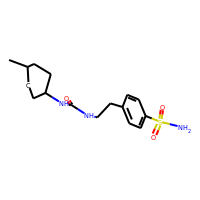
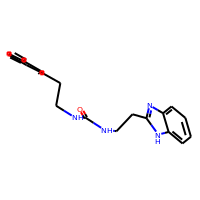
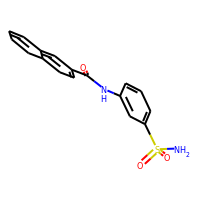
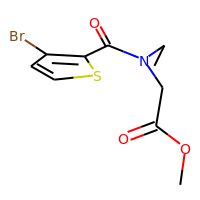
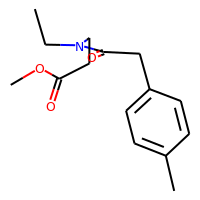
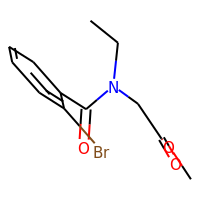
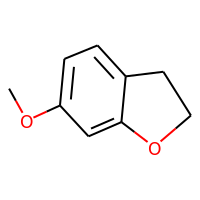
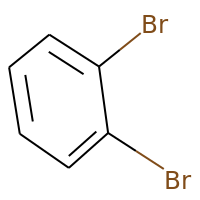

In [33]:
PandasTools.ChangeMoleculeRendering(renderer='PNG')
PandasTools.RenderImagesInAllDataFrames(images=True)
display(sortedscores)

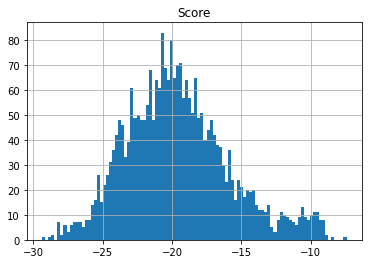

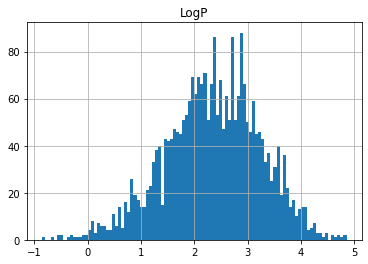

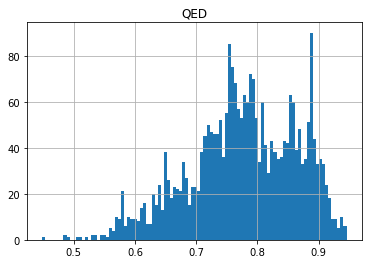

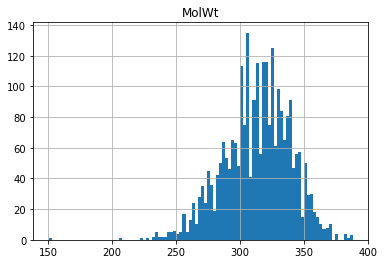

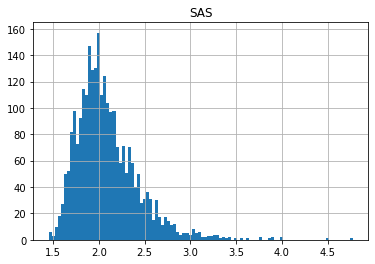

In [33]:
# plot histograms for the properties
import matplotlib.pyplot as plt
for c in allscores.columns:
    if allscores[c].dtype == float:
        allscores[c].hist(bins=100)
        plt.title(c)
        plt.show()

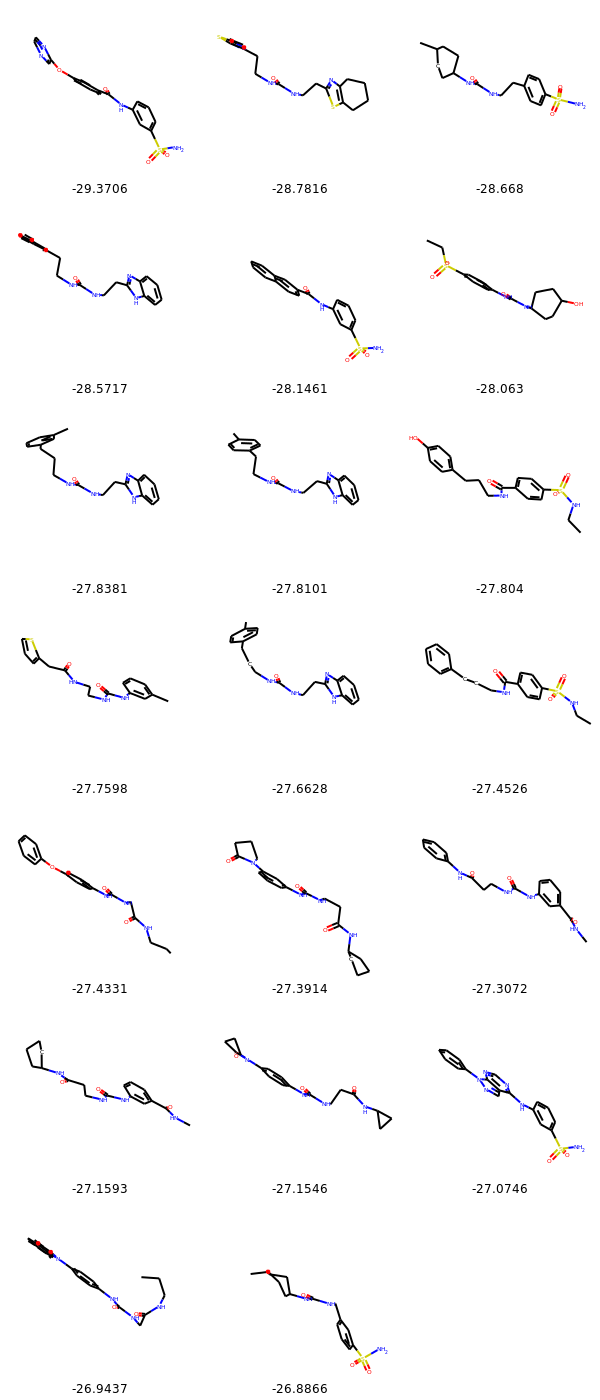

In [35]:
# Only 3D depiction available here
PandasTools.FrameToGridImage(sortedscores[:20], column='Mol', legendsCol='Score')

### Draw molecules

In [9]:
# Final list of sorted mols to be displayed
draw_mols = sortedscores.Mol.to_list()
# Set labels using docking scores
l = [str(x)+' kcal/mol' for x in sortedscores.Score.to_list()]
# Generate 2D coordiantes
for m in best_mols:
    AllChem.Compute2DCoords(m)

In [10]:
# Draw svg
svg = Draw.MolsToGridImage(draw_mols[:30], subImgSize = (300,300), legends = l, useSVG =True)

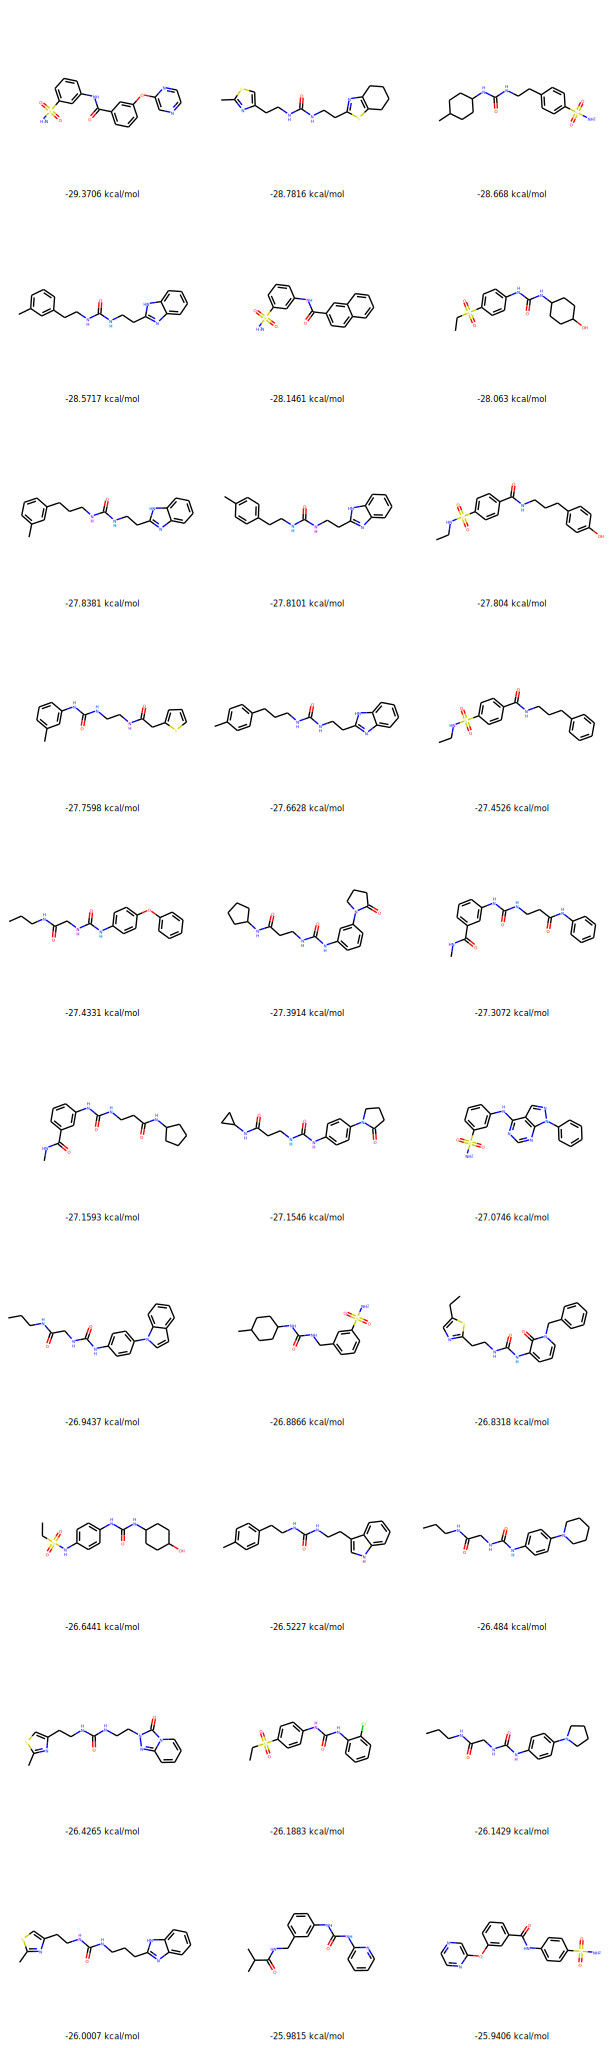

In [11]:
display(svg)

In [12]:
# Save svg image
with open(directory+'/Designs.svg','w') as f:
    f.write(svg.data)